Cargo las librerías:

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import GridSearchCV
import numpy as np
from datetime import datetime
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

Cargo los datos:

In [2]:
X_train = pd.read_csv('X_train_ns.csv')
del X_train['Unnamed: 0']
y_train = pd.read_csv('log_y_train.csv')
del y_train['Unnamed: 0']

Par evitar la maldición de la dimensionalidad, antes de emplear KNN reduciré las dimensiones aplicando PCA. Escojo el número de componentes para PCA y de vecinos para KNN por medio de GridSearch:

In [3]:
now1 = datetime.now()

pipe = Pipeline([
    ('pca', PCA()), 
    ('knn', KNeighborsRegressor()),
])

comps = [1,2,3,4,5,10,20]
ks = [1,5,10,20]
h_parameters = {'knn__n_neighbors':ks, 'pca__n_components':comps}

cv = GridSearchCV(pipe, h_parameters, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

cv.fit(X_train, y_train)

print(cv.cv_results_['params'][np.argsort(cv.cv_results_['rank_test_score'])[0]])

print(cv.best_score_)

now2 = datetime.now()
now2-now1

{'knn__n_neighbors': 10, 'pca__n_components': 20}
-0.17709565975509137


datetime.timedelta(seconds=8, microseconds=345920)

Repito el GridSearch, esta vez con valores cercanos a los óptimos del GridSearch anterior, en el cual probe relativamente pocos valores por el coste computacional:

In [4]:
now1 = datetime.now()

pipe = Pipeline([
    ('pca', PCA()), 
    ('knn', KNeighborsRegressor()),
])

comps = [20,30,40]
ks = [5,6,7,8,9,10,11,12,13,14,15]
h_parameters = {'knn__n_neighbors':ks, 'pca__n_components':comps}

cv = GridSearchCV(pipe, h_parameters, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

cv.fit(X_train, y_train)

print(cv.cv_results_['params'][np.argsort(cv.cv_results_['rank_test_score'])[0]])

print(cv.best_score_)

now2 = datetime.now()
now2-now1

{'knn__n_neighbors': 9, 'pca__n_components': 30}
-0.1670060969425478


datetime.timedelta(seconds=31, microseconds=979133)

De nuevo, repito el GridSearch, con valores cercanos a los óptimos del GridSearch anterior:

In [5]:
now1 = datetime.now()

pipe = Pipeline([
    ('pca', PCA()), 
    ('knn', KNeighborsRegressor()),
])

comps = [25,27,28,29,30,31,32,33,35]
ks = [8,9,10]
h_parameters = {'knn__n_neighbors':ks, 'pca__n_components':comps}

cv = GridSearchCV(pipe, h_parameters, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

cv.fit(X_train, y_train)

print(cv.cv_results_['params'][np.argsort(cv.cv_results_['rank_test_score'])[0]])

print(cv.best_score_)

now2 = datetime.now()
now2-now1

{'knn__n_neighbors': 9, 'pca__n_components': 30}
-0.16700029911022662


datetime.timedelta(seconds=26, microseconds=35088)

El número de vecinos óptimo es 9, y el número de componentes de PCA óptimas es 30.

La ventaja de hacer 3 GridSearchs con meno valores en lugar de uno con más valores es computacional. El Grid final tiene una precisión de 1 (los valores del Grid están separados 1 entre sí), de haber hecho desde el inicio un GridSearch con esa precisión habría tenido que entrenar el siguiente número de modelos:

In [11]:
print("De haber hecho un Grid con precisión 1 para todo el espacio de parámetros, habría tenido que entrenar",
     len(X_train.columns)*20,
      "modelos, suponiendo que busco un número de vecinos de 20 como máximo.")

De haber hecho un Grid con precisión 1 para todo el espacio de parámetros, habría tenido que entrenar 1000 modelos, suponiendo que busco un número de vecinos de 20 como máximo.


Esto no es viable computacionalmente. Sin embargo, la cantidad de modelos que he entrenado en los tres GrisSearchs que he hecho es de:

In [12]:
7*4 + 11*3 + 9*3

88

In [13]:
print("He entrenado",round(1000/88),
      "veces menos modelos que haciendo un Grid de precisión 1 desde el principio.")

He entrenado 11 veces menos modelos que haciendo un Grid de precisión 1 desde el principio.


Y, sin embargo, mi Grid final si tiene precisión 1.

Defino el modelo hallado como óptimo:

In [6]:
PKNN = Pipeline([
    ('pca', PCA(n_components=30)), 
    ('knn', KNeighborsRegressor(n_neighbors=9)),
])

Lo entreno, y hago las predicciones con el modelo.

In [7]:
now1 = datetime.now()
PKNN.fit(X_train,y_train)
Preds_train = PKNN.predict(X_train)
datetime.now() - now1

datetime.timedelta(seconds=2, microseconds=584670)

El error cuadrático medio sobre train es:

In [8]:
sk.metrics.mean_squared_error(Preds_train, y_train)

0.12933987531270616

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


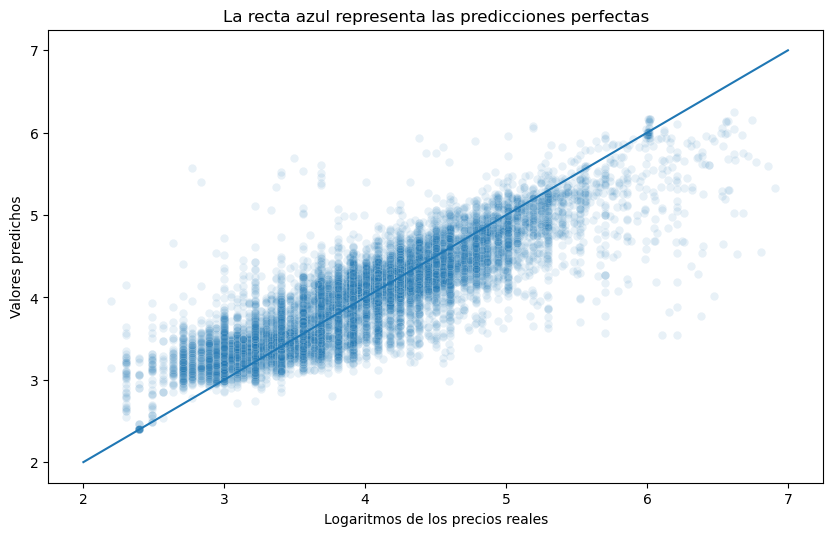

In [15]:
objetivo = list(list(np.array(y_train).reshape(1,-1))[0])

plt.figure(dpi=100, figsize=(10, 6))
sns.scatterplot(objetivo,Preds_train.reshape(1,-1)[0],alpha=0.1)
plt.plot((2,7), (2,7))

plt.title("La recta azul representa las predicciones perfectas")
plt.xlabel('Logaritmos de los precios reales')
plt.ylabel('Valores predichos')
plt.show()

Los precios reales se acumulan en ciertos valores (enteros), por eso están acumulados en columnas en el gráfico.